In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(monocle))

# Normalization & Scaling

## Normalization Strategies

The simpleset normalization is to normalize to the library size and can be shown to be biased even for bulk RNAseq .  Initially many of the  more advanced normailzation techniques used were borrowed from applications developed for bulk RNASeq. This is often done by assuming that most genes are not differentially expressed (DE) between cells. Any systematic difference in count size across the non-DE majority of genes between two cells is assumed to represent bias and is removed by scaling. More specifically, __“size factors”__ are calculated that represent the extent to which counts should be scaled in each library. However, these methods __are shown to perform poorly, , due to the dominance of low and zero counts,__ relative to methods specific to scRNASeq, which account for the "drop outs".

A variety of scRNA-seq-tailored methods that outperform bulk strategies have recently been proposed. One recent example of such an approach is __*scran*__, which pools multiple cells in order to estimate cell-specific size factors more robustly in the presence of zero inflation and unbalanced differential expression of genes across groups of cells. In principle, __BASiCS__ also provides a generic normalization tool, but its implementation has been coupled with specific downstream analysis.

Other recent examples of normalization methods specifically designed for scRNA-seq include GRM35 and SAMstrt36, which both rely on spike-ins, and SCnorm (_Specifically recommend not to use with UMI data which is sparse_), which uses quantile regression to group genes with similar dependence on sequencing depth and to estimate different scaling factors for each group. However, it should be noted that GRM is not a between-sample normalization method, but rather a method to denoise gene expression levels within each cell.


Finally, we note that, although the various global scaling methods rely on different assumptions, these methods all fail if the number or fold change of differentially expressed genes across the cell population is too high. One strategy to alleviate this issue is to precluster the cells into smaller, more homogeneous sets (using, e.g., rank-based clustering methods, which are unaffected by global-scaling normalization). Normalization can then be performed separately for each cluster before between-cluster normalization to calculate cluster-specific offsets. This approach is used in the __*scran*__ method and has been shown to yield more accurate estimates of scaling factors. 

Spike-in sequences have also been used for normalisation, but using spike-in sequences remains challenging. In particular, calibrating the added number of spike-in molecules is nontrivial and depends on intrinsic characteristics of the studied cells, such as endogenous mRNA content. Poor calibration can invalidate the utility of the spike-ins as control genes; too many spike-ins can overwhelm signal from the intrinsic genes, while the majority of spike-in sequences can be unusable in downstream analysis if too few spike-in molecules are added.

### Lets explore using the __*scran*__ package to Normalize here

The __*`computeSumFactors`*__ function from __*`scran`*__ pools counts from many cells to increase the count size for accurate size factor estimation (Lun, Bach, and Marioni 2016). Pool-based size factors are then “deconvolved” into cell-based factors for cell-specific normalization.

In [2]:
load(file="~/workshop_materials/scrna_workshop_data/pbmc_3k_sce_filt.rda")

In [3]:
sce.filt <- computeSumFactors(sce.filt)
summary(sizeFactors(sce.filt))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05099 0.71349 0.92755 1.00000 1.23114 6.60759 

<div class="time">
    user     system elapsed <br>
    156.848   5.168 162.137 
 </div>


Let us look at the relationship of these size factors to the library sizes

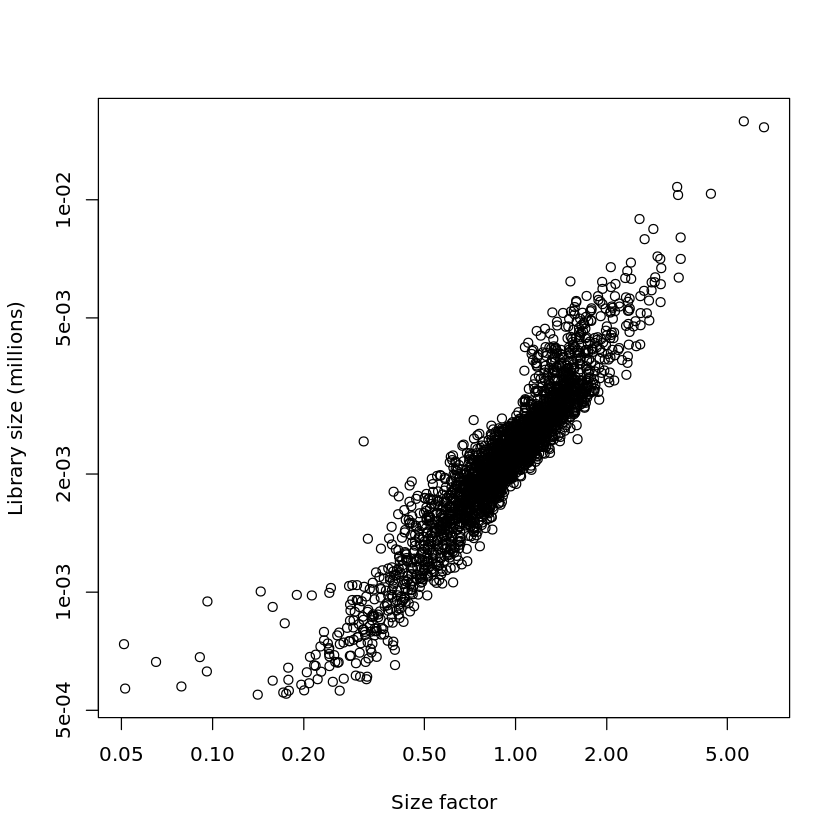

In [4]:
plot(sizeFactors(sce.filt), sce.filt$total_counts/1e6, log="xy",ylab="Library size (millions)", xlab="Size factor")

<div class="alert alert-block alert-warning">
<i><b>INFO</b></i> 
The function <code>computeSumFactors</code> can Also be used to Normalize based on spike-in counts if those are present

For highly heterogeneous data sets, it is advisable to perform a rough clustering of the cells, which can  then be passed on the the <code>computeSumFactors</code> function. This may occur in larger datasets and then the <b>size factors</b> are calculated independently for each pool 
<br><br>


<code>clusters <- quickCluster(sce.filt)</code>
    
<br>
    
<code>larger.sce <- computeSumFactors(sce.filt, cluster=clusters)</code>
    

 
 <br><br>The above code is not run as it takes some time shown below
 
 </div>
 

<div class="time">
    user   system  elapsed <br>
1377.288    0.556 1378.306 
</div>

Normalize the data

In [5]:
tail(exprs(sce.filt))

,AAACATACAACCAC,AAACATTGAGCTAC,AAACATTGATCAGC,AAACCGTGCTTCCG,AAACCGTGTATGCG,AAACGCACTGGTAC,AAACGCTGACCAGT,AAACGCTGGTTCTT,AAACGCTGTAGCCA,AAACGCTGTTTCTG,⋯,TTTCAGTGTCACGA,TTTCAGTGTCTATC,TTTCAGTGTGCAGT,TTTCCAGAGGTGAG,TTTCGAACACCTGA,TTTCGAACTCTCAT,TTTCTACTGAGGCA,TTTCTACTTCCTCG,TTTGCATGAGAGGC,TTTGCATGCCTCAC
AL592183.1,0,0.5682708,0,0,0,0,0,0,0,0,⋯,0,0,0,0.00000,0,0,0,0,0.000000,0
AC011841.1,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,0.00000,0,0,0,0,0.000000,0
AL354822.1,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,0.00000,0,0,0,0,1.727453,0
KIR2DL2,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,0.00000,0,0,0,0,0.000000,0
PNRC2.1,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,0.00000,0,0,0,0,0.000000,0
SRSF10.1,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,1.05815,0,0,0,0,0.000000,0


In [6]:
sce.filt <- normalize(sce.filt,exprs_values="counts")

Warning message in .local(object, ...):
“spike-in transcripts in 'MT' should have their own size factors”

In [7]:
tail(exprs(sce.filt))

,AAACATACAACCAC,AAACATTGAGCTAC,AAACATTGATCAGC,AAACCGTGCTTCCG,AAACCGTGTATGCG,AAACGCACTGGTAC,AAACGCTGACCAGT,AAACGCTGGTTCTT,AAACGCTGTAGCCA,AAACGCTGTTTCTG,⋯,TTTCAGTGTCACGA,TTTCAGTGTCTATC,TTTCAGTGTGCAGT,TTTCCAGAGGTGAG,TTTCGAACACCTGA,TTTCGAACTCTCAT,TTTCTACTGAGGCA,TTTCTACTTCCTCG,TTTGCATGAGAGGC,TTTGCATGCCTCAC
AL592183.1,0,0.4874816,0,0,0,0,0,0,0,0,⋯,0,0,0,0.000000,0,0,0,0,0.000000,0
AC011841.1,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,0.000000,0,0,0,0,0.000000,0
AL354822.1,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,0.000000,0,0,0,0,1.923047,0
KIR2DL2,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,0.000000,0,0,0,0,0.000000,0
PNRC2.1,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,0.000000,0,0,0,0,0.000000,0
SRSF10.1,0,0.0000000,0,0,0,0,0,0,0,0,⋯,0,0,0,1.003174,0,0,0,0,0.000000,0


## Modelling the technical noise in gene expression

Variability in the observed expression values across genes can be driven by genuine biological heterogeneity or uninteresting technical noise. To distinguish between these two possibiltiies, we need to model the technical component of the variance of the expression values for each gene, which can be done with the ___`trendVar`___ function from the __`Scran`__ package. This function allows for trendfitting both, with Spike-Ins and with endogenous gene sets

### Trend fitting when spike-ins are unavailable
If spike-in RNA has not been added in appropriate quantities, an alternative approach is to fit the trend to the variance estimates of the endogenous genes. This is done using the use.spikes=FALSE setting in trendVar, as shown below.

In [8]:
var.fit.nospike <- trendVar(sce.filt, parametric=TRUE, use.spikes=FALSE, span=0.2)

In [9]:
var.out.nospike <- decomposeVar(sce.filt, var.fit.nospike)
head(var.out.nospike)

,mean,total,bio,tech,p.value,FDR
AL627309.1,0.0032598568,0.0033362834,-3.152837e-04,0.0036515671,0.9994407,1
AP006222.2,0.0011337210,0.0011913085,-7.864246e-05,0.0012699510,0.9896793,1
RP11-206L10.2,0.0014024428,0.0012092252,-3.617377e-04,0.0015709629,1.0000000,1
RP11-206L10.9,0.0007946432,0.0005696647,-3.204642e-04,0.0008901289,1.0000000,1
FAM87B,0.0005633231,0.0004315525,-1.994606e-04,0.0006310130,1.0000000,1
LINC00115,0.0068307272,0.0072415910,-4.099269e-04,0.0076515179,0.9769929,1


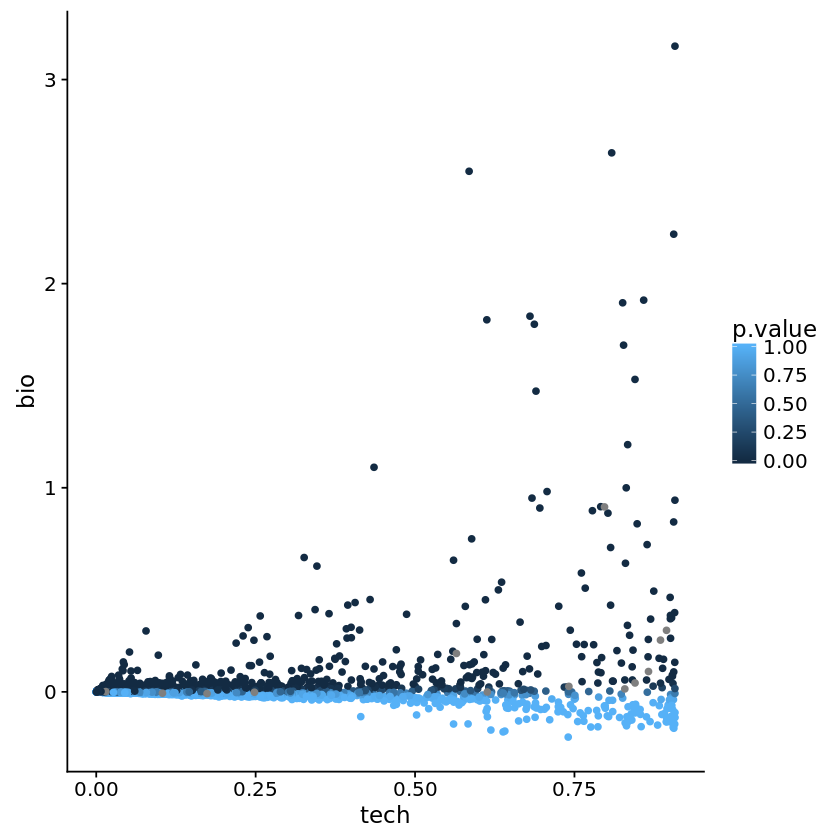

In [10]:
ggplot(var.out.nospike, aes(x=tech, y=bio, color=p.value))+geom_point()

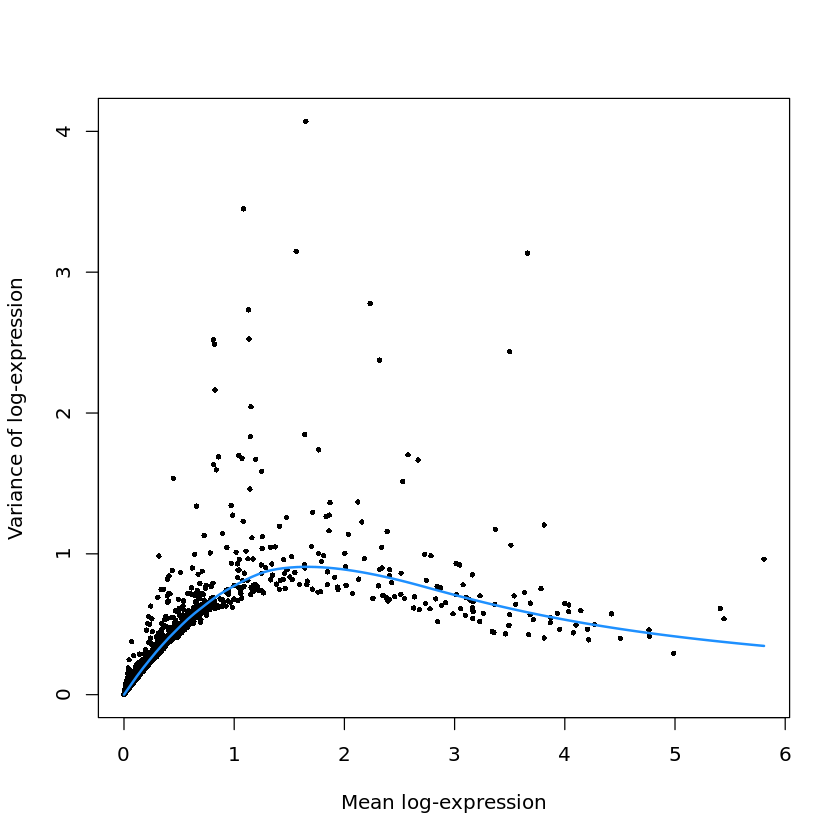

In [11]:
plot(var.out.nospike$mean, var.out.nospike$total, pch=16, cex=0.6, 
    xlab="Mean log-expression", ylab="Variance of log-expression")
curve(var.fit.nospike$trend(x), col="dodgerblue", lwd=2, add=TRUE)
#points(var.out.nospike$mean[cur.spike], var.out.nospike$total[cur.spike], col="red", pch=16)

### Modelling and removing technical noise

We model the technical noise by fitting a mean-variance trend to the spike-in transcripts or the endogenous genes, as previously described. Furthermore, to account for uninteresting factors, we can also supply a design matrix to the ___`trendVar`___ function to regress out any technical differences due to variables in the design.

In [12]:
names(colData(sce.filt))

[1] "total_features"                        
 [2] "log10_total_features"                  
 [3] "total_counts"                          
 [4] "log10_total_counts"                    
 [5] "pct_counts_top_50_features"            
 [6] "pct_counts_top_100_features"           
 [7] "pct_counts_top_200_features"           
 [8] "pct_counts_top_500_features"           
 [9] "total_features_endogenous"             
[10] "log10_total_features_endogenous"       
[11] "total_counts_endogenous"               
[12] "log10_total_counts_endogenous"         
[13] "pct_counts_endogenous"                 
[14] "pct_counts_top_50_features_endogenous" 
[15] "pct_counts_top_100_features_endogenous"
[16] "pct_counts_top_200_features_endogenous"
[17] "pct_counts_top_500_features_endogenous"
[18] "total_features_feature_control"        
[19] "log10_total_features_feature_control"  
[20] "total_counts_feature_control"          
[21] "log10_total_counts_feature_control"    
[22] "pct_counts_feature_control"            
[23] "total_features_MT"                     
[24] "log10_total_features_MT"               
[25] "total_counts_MT"                       
[26] "log10_total_counts_MT"                 
[27] "pct_counts_MT"                         
[28] "is_cell_control"                       
[29] "cycle_phases"                          
[30] "G1"                                    
[31] "S"                                     
[32] "G2M"                                   
[33] "use"

Here we will use the cell cycle Phase assignment as a regressor

In [13]:
design <- model.matrix(~cycle_phases,colData(sce.filt))
head(design)

,(Intercept),cycle_phasesG2M,cycle_phasesS
AAACATACAACCAC,1,0,0
AAACATTGAGCTAC,1,0,0
AAACATTGATCAGC,1,0,0
AAACCGTGCTTCCG,1,0,0
AAACCGTGTATGCG,1,0,1
AAACGCACTGGTAC,1,0,0


In [14]:
system.time(var.fit.nospike.dsgn <- trendVar(sce.filt, parametric=TRUE, span=0.4, design=design))

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 2.8416”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.52292”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 2.8416”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.52292”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 2.8416”Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.52292”Warning message in simpleLoess(y, x, w,

   user  system elapsed 
  0.516   0.168   0.684 

In [15]:
system.time(var.out.nospike.dsgn <- decomposeVar(sce.filt, var.fit.nospike.dsgn))
head(var.out.nospike.dsgn)

   user  system elapsed 
  0.700   0.164   0.865 

,mean,total,bio,tech,p.value,FDR
AL627309.1,0.0032598568,0.0033380918,3.296686e-05,0.0033051249,0.35414978,0.48079094
AP006222.2,0.0011337210,0.0011901048,4.064034e-05,0.0011494645,0.09811036,0.14999044
RP11-206L10.2,0.0014024428,0.0012035150,-2.184029e-04,0.0014219179,1.00000000,1.00000000
RP11-206L10.9,0.0007946432,0.0005700476,-2.356304e-04,0.0008056780,1.00000000,1.00000000
FAM87B,0.0005633231,0.0004318526,-1.392931e-04,0.0005711457,1.00000000,1.00000000
LINC00115,0.0068307272,0.0072440382,3.184590e-04,0.0069255792,0.04722088,0.07681134


In [16]:
#g1 <-ggplot(var.out.nospike, aes(x=tech, y=bio, color=FDR))+geom_point()

In [17]:
#var.out.nospike.sig_bio <- rep("yes", nrow(var.out.nospike))
#var.out.nospike.sig_bio[var.out.nospike$FDR > 0.005] <-"NO"
#g2 <- ggplot(var.out.nospike, aes(x=tech, y=bio, color=var.out.nospike.sig_bio))+geom_point()
#multiplot(g1,g2,cols = 1)

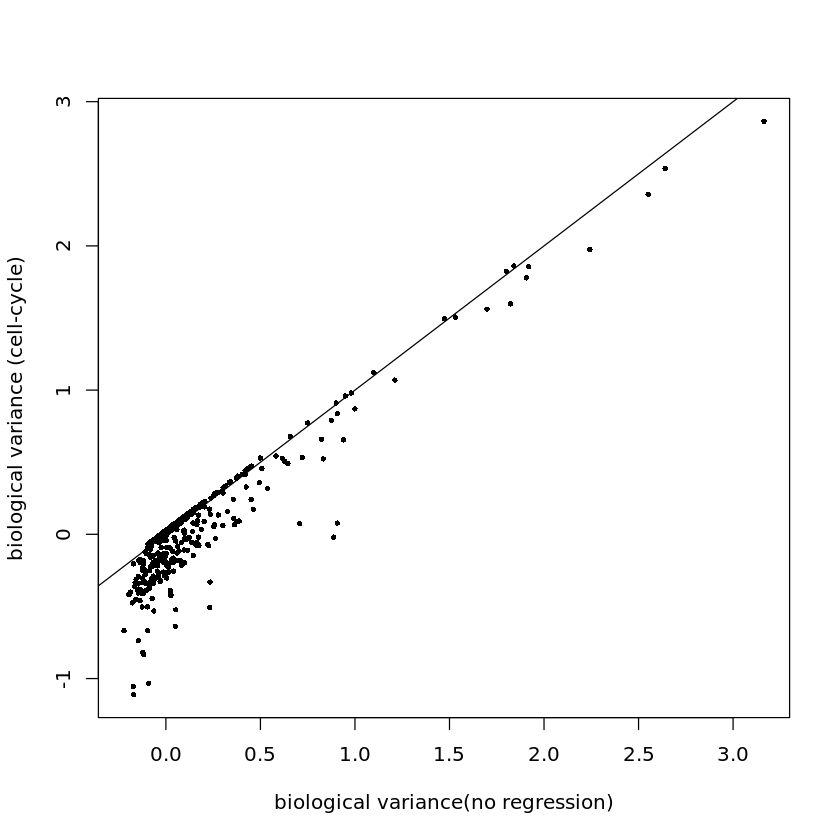

In [18]:
plot(var.out.nospike$bio, var.out.nospike.dsgn$bio, pch=16, cex=0.6, 
    xlab="biological variance(no regression)", ylab="biological variance (cell-cycle)")
abline(0,1)

Lets see what genes are at the top of the list

In [19]:
fontsize <- theme(axis.text=element_text(size=12), axis.title=element_text(size=16))

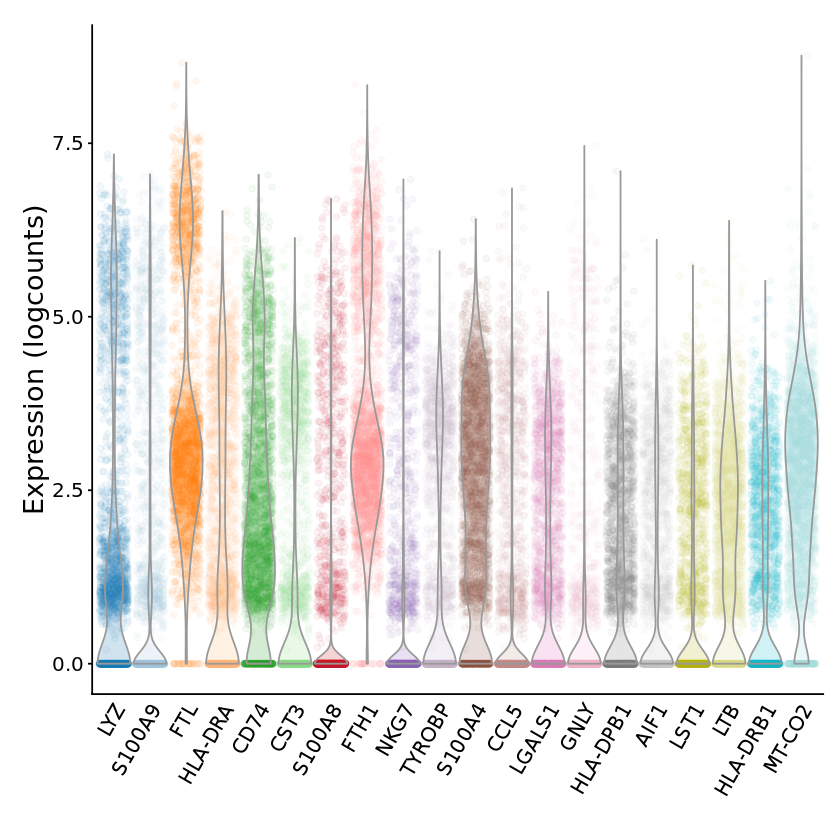

In [20]:
chosen.genes <- order(var.out.nospike$bio, decreasing=TRUE)[1:20]
plotExpression(sce.filt, rownames(var.out.nospike)[chosen.genes], alpha=0.05, jitter="jitter") + fontsize

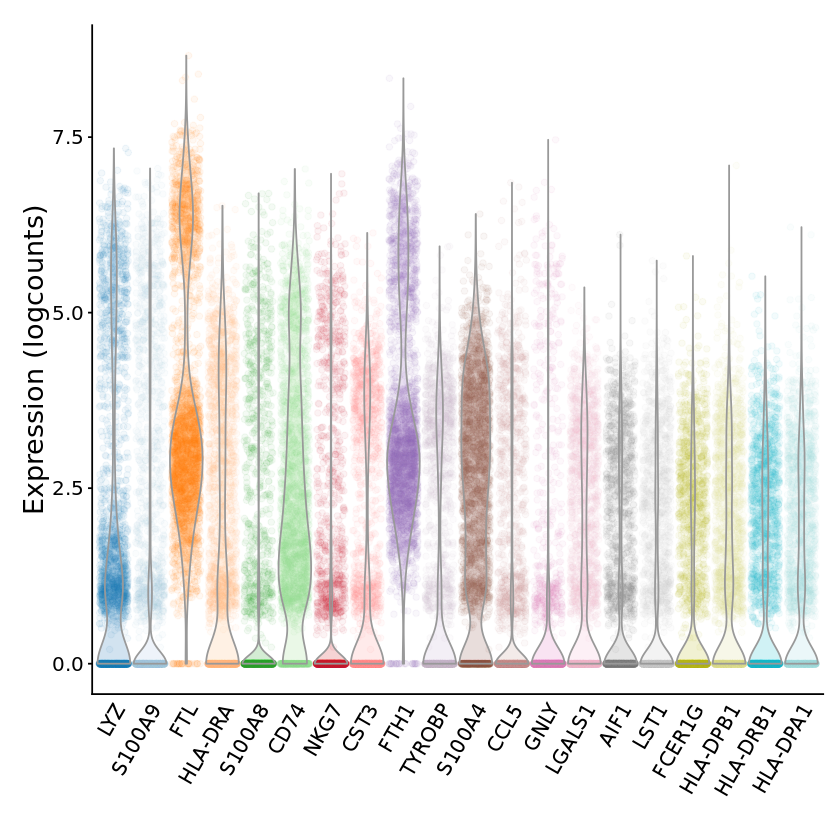

In [21]:
chosen.genes <- order(var.out.nospike.dsgn$bio, decreasing=TRUE)[1:20]
plotExpression(sce.filt, rownames(var.out.nospike.dsgn)[chosen.genes], alpha=0.05, jitter="jitter") + fontsize

### Denoising expression values using PCA
Once the technical noise is modelled, we can use principal components analysis (PCA) to remove random technical noise. Consider that each cell represents a point in the high-dimensional expression space, where the spread of points represents the total variance. PCA identifies axes in this space that capture as much of this variance as possible. Each axis is a principal component (PC), where any early PC will explain more of the variance than a later PC.

We assume that biological processes involving co-regulated groups of genes will account for the most variance in the data. If this is the case, this process should be represented by one or more of the earlier PCs. In contrast, random technical noise affects each gene independently and will be represented by later PCs. The denoisePCA function removes later PCs until the total discarded variance is equal to the sum of technical components for all genes used in the PCA.

In [22]:
system.time(sce2 <- denoisePCA(sce.filt, technical=var.fit.nospike.dsgn$trend) )
dim(reducedDim(sce2, "PCA")) 

   user  system elapsed 
385.784   0.808 386.597 

[1] 2700   11

It is also possible to obtain a low-rank approximation of the original expression matrix, capturing the variance equivalent to the retained PCs. This is useful for denoising prior to downstream procedures that require gene-wise expression values.

In [23]:
sce2_lr <- denoisePCA(sce2, technical=var.fit.nospike$trend, value="lowrank") 
assayNames(sce2_lr)

[1] "counts"    "logcounts" "lowrank"

### Data exploration with dimensionality reduction
We visualize the relationships between cells by constructing pairwise PCA plots for the first three components (Figure 12). Cells with similar expression profiles should be located close together in the plot, while dissimilar cells should be far apart. In this case, no clear separation of cells into distinct subpopulations is observed. This is consistent with the presence of a highly homogeneous population of HSCs (N. K. Wilson et al. 2015).

In [24]:
IRdisplay::display_html('<iframe src="https://distill.pub/2016/misread-tsne/" width=1000, height=500> </iframe>')

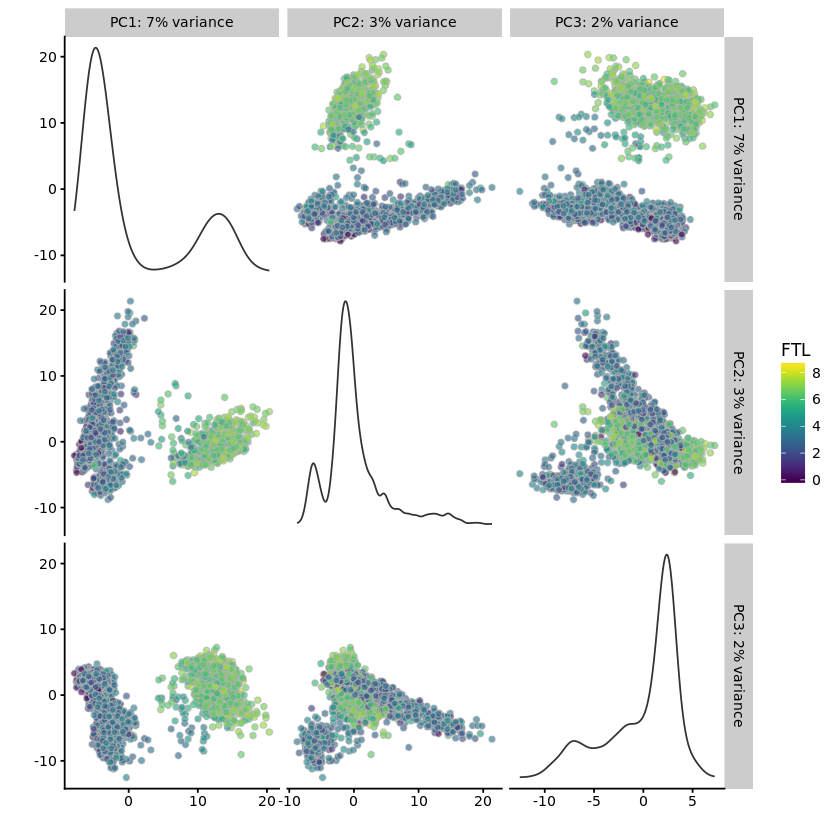

In [25]:
plotReducedDim(sce2, use_dimred="PCA", ncomponents=3, colour_by="FTL")

Another widely used approach is the t-stochastic neighbour embedding (t-SNE) method (Van der Maaten and Hinton 2008). t-SNE tends to work better than PCA for separating cells in more diverse populations. This is because the former can directly capture non-linear relationships in high-dimensional space, whereas the latter must represent them on linear axes. However, this improvement comes at the cost of more computational effort and requires the user to consider parameters such as the random seed and perplexity (see comments). We demonstrate the generation of t-SNE plots in Figure 13, using the low-rank approximation of the data to take advantage of the denoising step. As with the PCA plots, no consistent substructure is observed.

In [26]:
    out5 <- plotTSNE(sce2, use_dimred="PCA", perplexity=5, colour_by="FTL", 
                     rand_seed=100) + fontsize + ggtitle("Perplexity = 50")

<div class="time">
    user  system elapsed 
 48.012  15.384  63.419 
 </div>

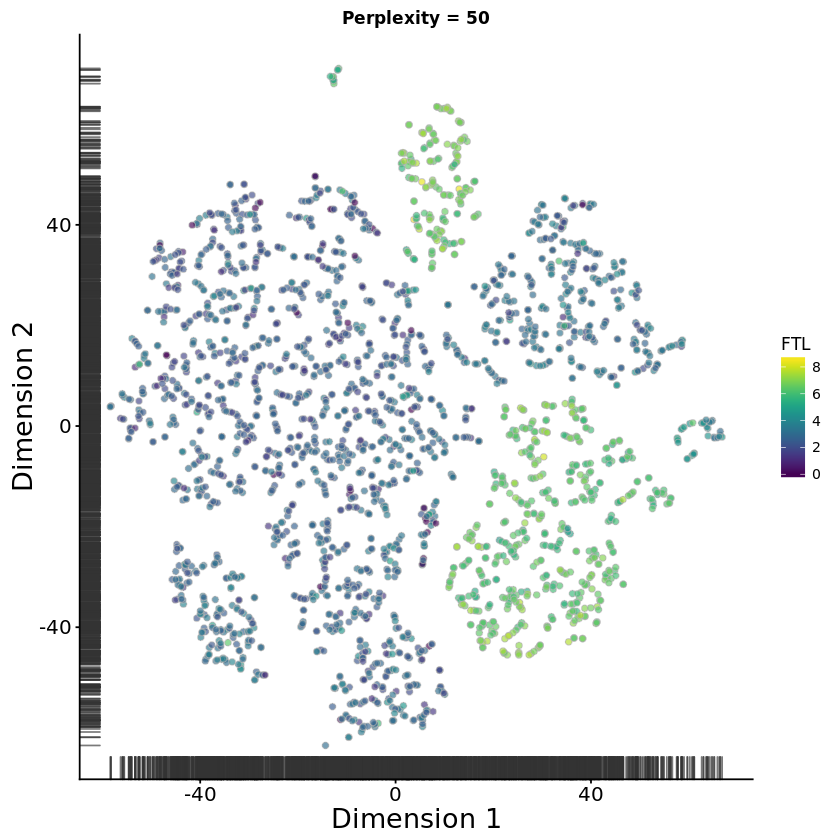

In [27]:
out5

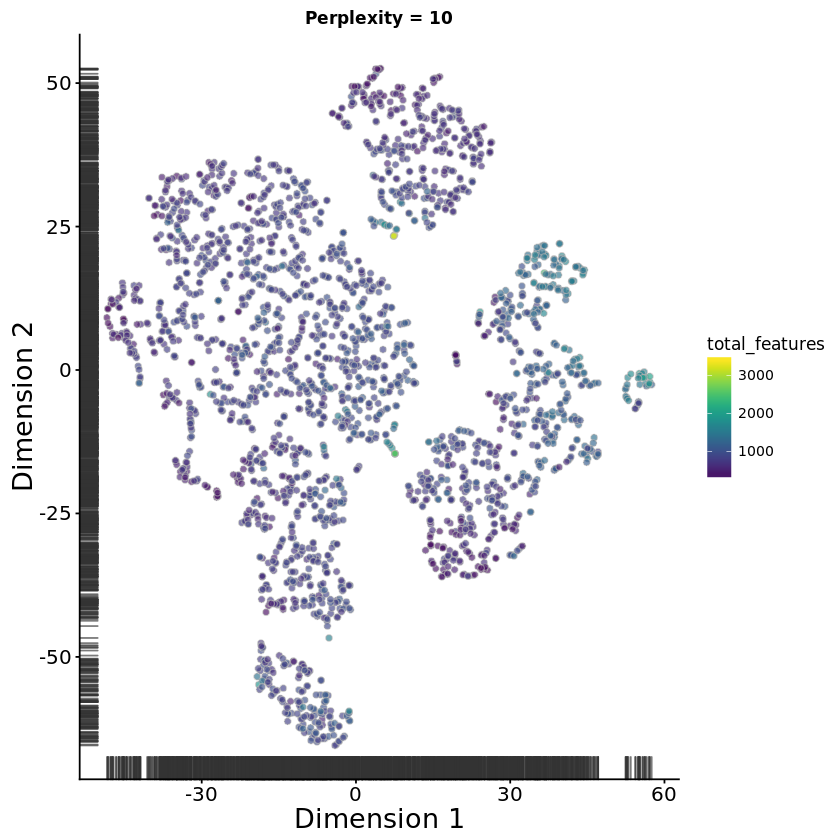

In [28]:
out10 <- plotTSNE(sce2, use_dimred="PCA", perplexity=10, colour_by="total_features",
    rand_seed=100) + fontsize + ggtitle("Perplexity = 10")
out10

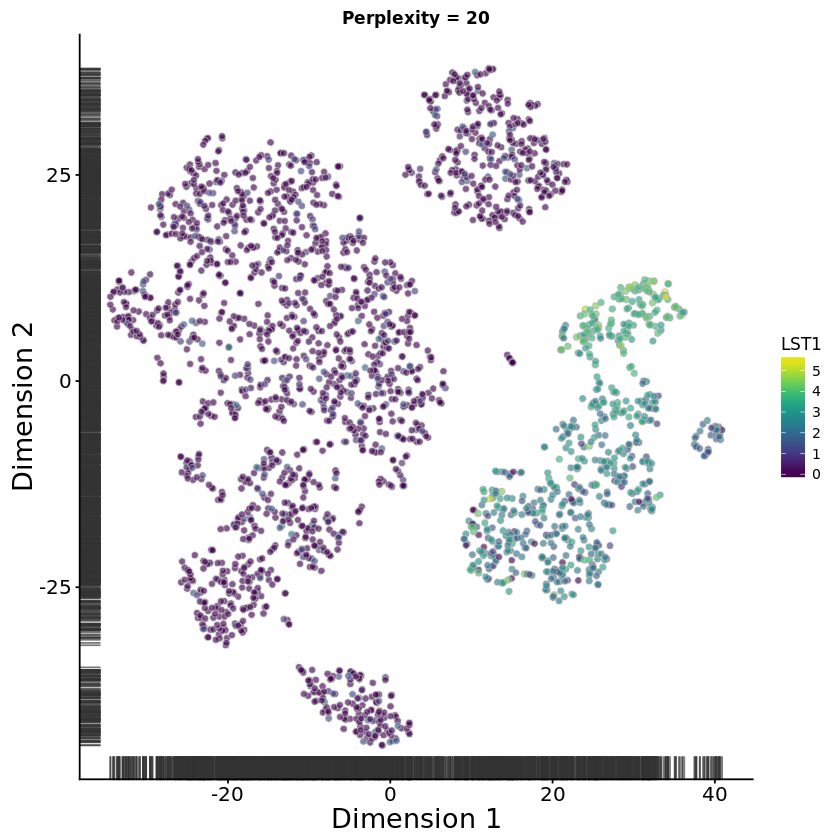

In [29]:
out20 <- plotTSNE(sce2, use_dimred="PCA", perplexity=20, colour_by="LST1",
    rand_seed=100) + fontsize + ggtitle("Perplexity = 20")
out20

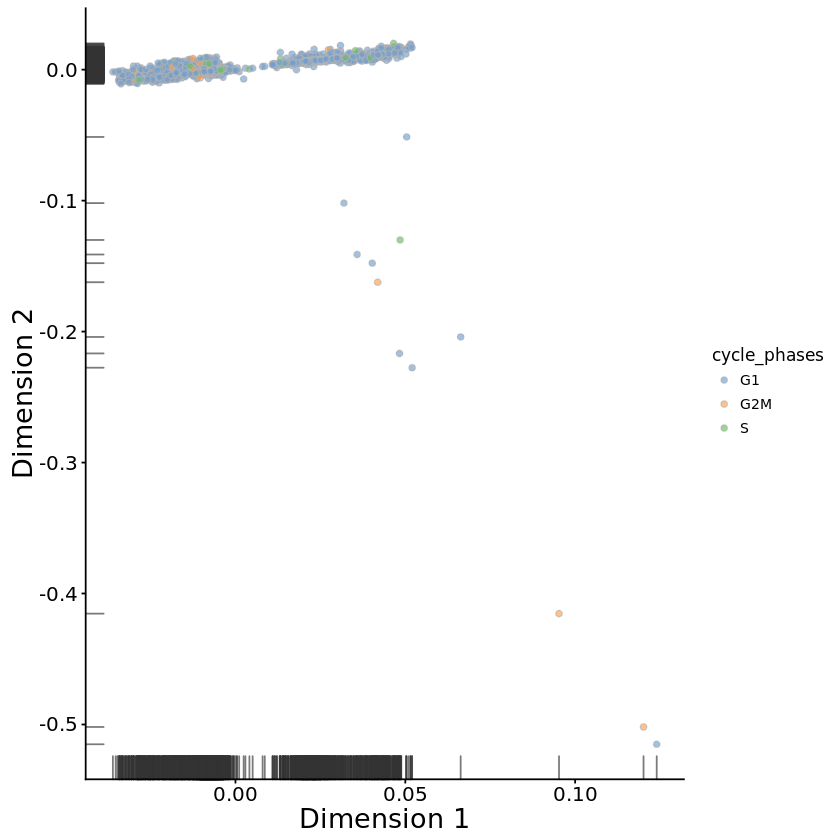

In [30]:
plotDiffusionMap(sce2, use_dimred="PCA", sigma=25, colour_by="cycle_phases") + fontsize

## Reverting to Seurat

<div class="extra"> 
    
<b>NOTE: Seurat Normalizing the data</b>

By default, <b><code>Seurat</code></b> employs a global-scaling normalization method “LogNormalize” that normalizes the gene expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. <br><br>


<code>pbmc <- NormalizeData(object = pbmc, normalization.method = "LogNormalize", scale.factor = 10000)</code>


</div>

In [31]:
pbmc <- CreateSeuratObject(raw.data = exprs(sce.filt),project = "10X_PBMC")

In [32]:
pbmc@meta.data <- cbind(pbmc@meta.data,as.data.frame(colData(sce.filt)))

In [33]:
pbmc@calc.params$NormalizeData <-list(assay.type="RNA",normalization.method="LogNormalize",scale.factor=NULL)

In [34]:
head(pbmc@meta.data)

,nGene,nUMI,orig.ident,total_features,log10_total_features,total_counts,log10_total_counts,pct_counts_top_50_features,pct_counts_top_100_features,pct_counts_top_200_features,⋯,log10_total_features_MT,total_counts_MT,log10_total_counts_MT,pct_counts_MT,is_cell_control,cycle_phases,G1,S,G2M,use
AAACATACAACCAC,781,1153.571,10X_PBMC,781,2.893207,2421,3.384174,47.74886,63.27964,74.96902,⋯,1.0413927,73,1.869232,3.0152829,FALSE,G1,0.989,0.263,0.002,TRUE
AAACATTGAGCTAC,1352,1148.963,10X_PBMC,1352,3.131298,4903,3.690550,45.50275,61.02386,71.81318,⋯,1.0413927,186,2.271842,3.7935958,FALSE,G1,0.541,0.659,0.045,TRUE
AAACATTGATCAGC,1131,1319.944,10X_PBMC,1131,3.053846,3149,3.498311,41.31470,53.79486,65.44935,⋯,0.9542425,28,1.462398,0.8891712,FALSE,G1,0.998,0.423,0.000,TRUE
AAACCGTGCTTCCG,960,1409.067,10X_PBMC,960,2.982723,2639,3.421604,39.02994,52.89883,66.69193,⋯,1.0413927,46,1.672098,1.7430845,FALSE,G1,0.947,0.088,0.079,TRUE
AAACCGTGTATGCG,522,1487.887,10X_PBMC,522,2.718502,981,2.992111,44.85219,55.65749,67.17635,⋯,0.7781513,12,1.113943,1.2232416,FALSE,S,0.428,0.292,0.202,TRUE
AAACGCACTGGTAC,782,1214.158,10X_PBMC,782,2.893762,2164,3.335458,46.71904,60.44362,71.62662,⋯,0.9030900,36,1.568202,1.6635860,FALSE,G1,0.965,0.092,0.049,TRUE


## Detection of variable genes across the single cells with Seurat

Seurat calculates highly variable genes and focuses on these for downstream analysis. FindVariableGenes calculates the average expression and dispersion for each gene, places these genes into bins, and then calculates a z-score for dispersion within each bin. This helps control for the relationship between variability and average expression. This function is unchanged from (Macosko et al.), but new methods for variable gene expression identification are coming soon. We suggest that users set these parameters to mark visual outliers on the dispersion plot, but the exact parameter settings may vary based on the data type, heterogeneity in the sample, and normalization strategy. The parameters here identify ~2,000 variable genes, and represent typical parameter settings for UMI data that is normalized to a total of 1e4 molecules.

[1] 2415

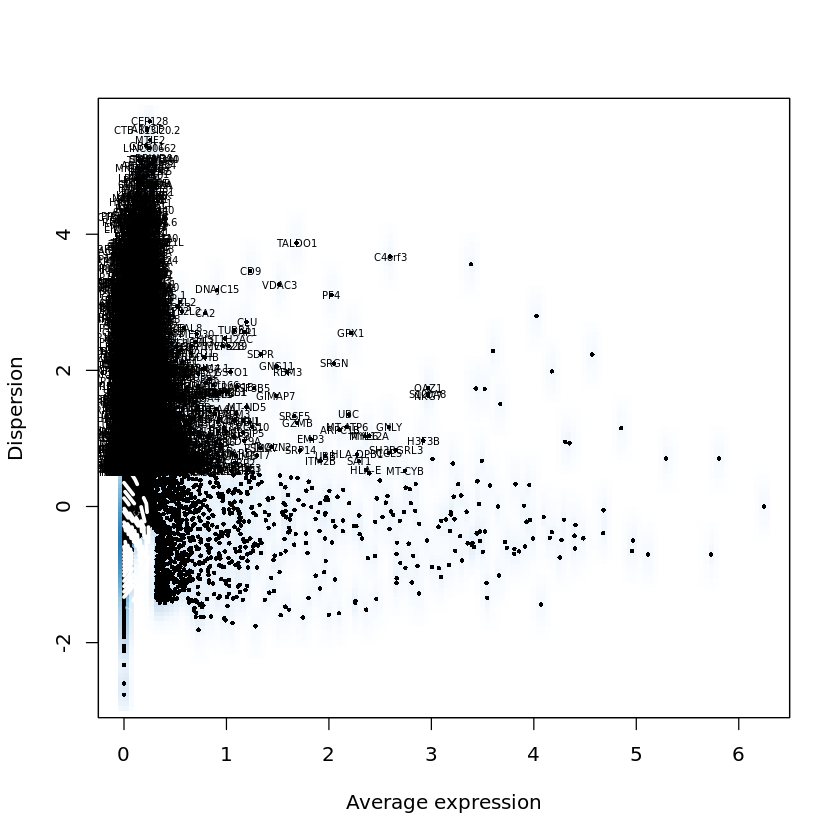

In [35]:
pbmc <- FindVariableGenes(object = pbmc, mean.function = ExpMean, dispersion.function = LogVMR,
                          x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5)
length(x = pbmc@var.genes)

## Scaling the data and removing unwanted sources of variation

Your single cell dataset likely contains ‘uninteresting’ sources of variation. This could include not only technical noise, but batch effects, or even biological sources of variation (cell cycle stage). As suggested in Buettner et al, NBT, 2015, regressing these signals out of the analysis can improve downstream dimensionality reduction and clustering. To mitigate the effect of these signals, Seurat constructs linear models to predict gene expression based on user-defined variables. The scaled z-scored residuals of these models are stored in the scale.data slot, and are used for dimensionality reduction and clustering.

We can regress out cell-cell variation in gene expression driven by batch (if applicable), cell alignment rate (as provided by Drop-seq tools for Drop-seq data), the number of detected molecules, and mitochondrial gene expression. For cycling cells, we can also learn a ‘cell-cycle’ score (see example here) and regress this out as well. In this simple example here for post-mitotic blood cells, we regress on the number of detected molecules per cell as well as the percentage mitochondrial gene content.

Seurat v2.0 implements this regression as part of the data scaling process. Therefore, the RegressOut function has been deprecated, and replaced with the vars.to.regress argument in ScaleData.

In [36]:
pbmc <- ScaleData(object = pbmc, vars.to.regress = c("nUMI", "pct_counts_MT","cycle_phases"))

[1] "Regressing out nUMI"          "Regressing out pct_counts_MT"
[3] "Regressing out cycle_phases" 
  |======================================================================| 100%
Time Elapsed:  55.8343892097473 secs
[1] "Scaling data matrix"
  |======================================================================| 100%


## Perform linear dimensional reduction

Next we perform PCA on the scaled data. By default, the genes in object@var.genes are used as input, but can be defined using pc.genes. We have typically found that running dimensionality reduction on highly variable genes can improve performance. However, with UMI data - particularly after regressing out technical variables, we often see that PCA returns similar (albeit slower) results when run on much larger subsets of genes, including the whole transcriptome.

In [37]:
pbmc <- RunPCA(object = pbmc, pc.genes = pbmc@var.genes, do.print = TRUE, pcs.print = 1:5, genes.print = 5)

[1] "PC1"
[1] "NKG7"   "CST7"   "FGFBP2" "CD247"  "GZMM"  
[1] ""
[1] "GPX1"      "NRGN"      "RGS18"     "PF4"       "HIST1H2AC"
[1] ""
[1] ""
[1] "PC2"
[1] "CCL5"   "MYL12A" "NKG7"   "CST7"   "GZMB"  
[1] ""
[1] "S100A8" "LGALS3" "NCF2"   "MS4A6A" "FCGRT" 
[1] ""
[1] ""
[1] "PC3"
[1] "CD79A"     "VPREB3"    "LINC00926" "HLA-DPB1"  "BANK1"    
[1] ""
[1] "NKG7"   "GZMB"   "FGFBP2" "CST7"   "GNLY"  
[1] ""
[1] ""
[1] "PC4"
[1] "AQP3"   "GIMAP7" "MAL"    "FYB"    "RGS10" 
[1] ""
[1] "CD79A"     "HLA-DPB1"  "LINC00926" "GZMB"      "VPREB3"   
[1] ""
[1] ""
[1] "PC5"
[1] "ACTN1"      "CLU"        "TREML1"     "GP9"        "AP001189.4"
[1] ""
[1] "DAPP1"     "WIPI1"     "SPOCD1"    "NEXN"      "LINC01003"
[1] ""
[1] ""


### Examine and visualize PCA results a few different ways

In [38]:
PrintPCA(object = pbmc, pcs.print = 1:5, genes.print = 5, use.full = FALSE)

[1] "PC1"
[1] "NKG7"   "CST7"   "FGFBP2" "CD247"  "GZMM"  
[1] ""
[1] "GPX1"      "NRGN"      "RGS18"     "PF4"       "HIST1H2AC"
[1] ""
[1] ""
[1] "PC2"
[1] "CCL5"   "MYL12A" "NKG7"   "CST7"   "GZMB"  
[1] ""
[1] "S100A8" "LGALS3" "NCF2"   "MS4A6A" "FCGRT" 
[1] ""
[1] ""
[1] "PC3"
[1] "CD79A"     "VPREB3"    "LINC00926" "HLA-DPB1"  "BANK1"    
[1] ""
[1] "NKG7"   "GZMB"   "FGFBP2" "CST7"   "GNLY"  
[1] ""
[1] ""
[1] "PC4"
[1] "AQP3"   "GIMAP7" "MAL"    "FYB"    "RGS10" 
[1] ""
[1] "CD79A"     "HLA-DPB1"  "LINC00926" "GZMB"      "VPREB3"   
[1] ""
[1] ""
[1] "PC5"
[1] "ACTN1"      "CLU"        "TREML1"     "GP9"        "AP001189.4"
[1] ""
[1] "DAPP1"     "WIPI1"     "SPOCD1"    "NEXN"      "LINC01003"
[1] ""
[1] ""


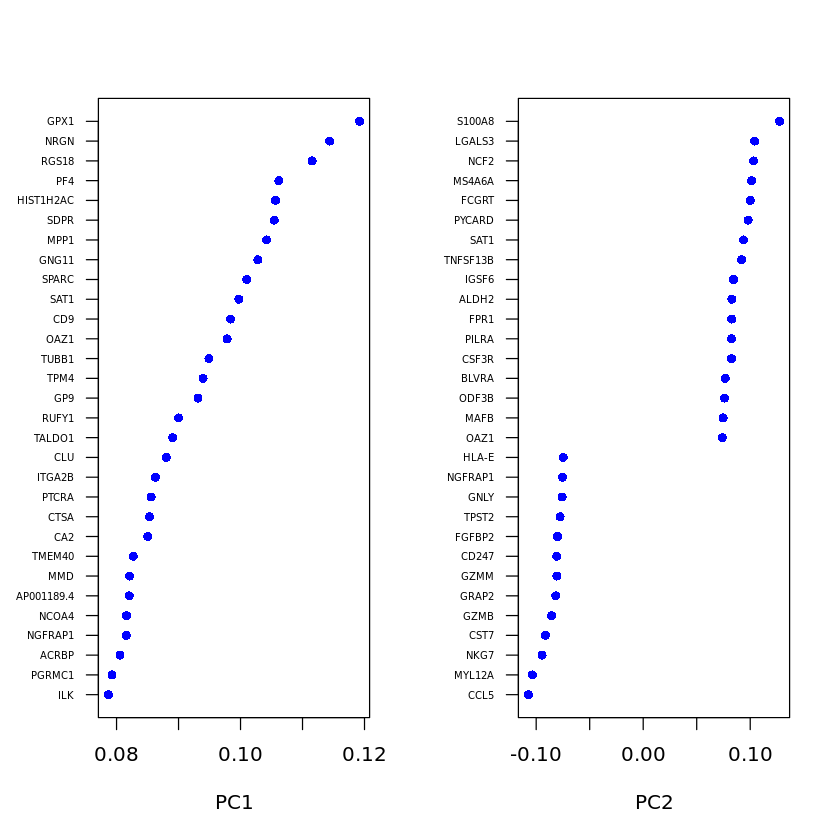

In [39]:
VizPCA(object = pbmc, pcs.use = 1:2)

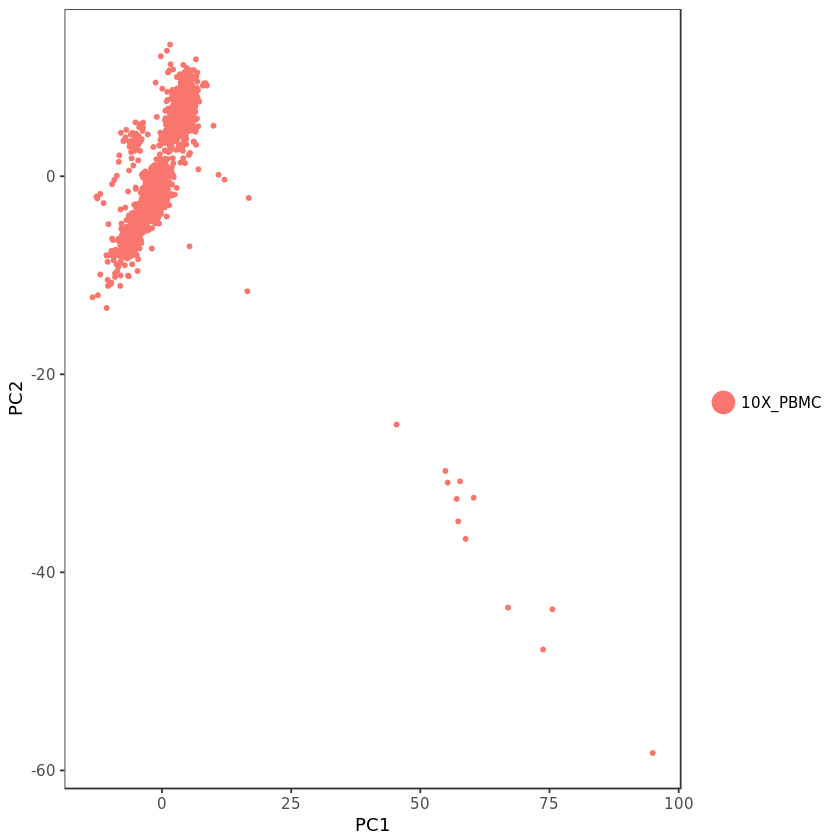

In [40]:
PCAPlot(object = pbmc, dim.1 = 1, dim.2 = 2)

<div class="alert alert-block alert-warning">

NOTE: ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation with the calculated components. Though we don't use this further here, it can be used to identify markers that are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.  The results of the projected PCA can be explored by setting use.full=T in the functions above. <br><br>

<code>pbmc <- ProjectPCA(object = pbmc, do.print = FALSE)</code>

</div>

In particular __PCHeatmap__ allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and genes are ordered according to their PCA scores. Setting cells.use to a number plots the ‘extreme’ cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated gene sets.

Warning message in heatmap.2(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in heatmap.2(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”Warning message in plot.window(...):
“"dimTitle" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"dimTitle" is not a graphical parameter”Warning message in title(...):
“"dimTitle" is not a graphical parameter”

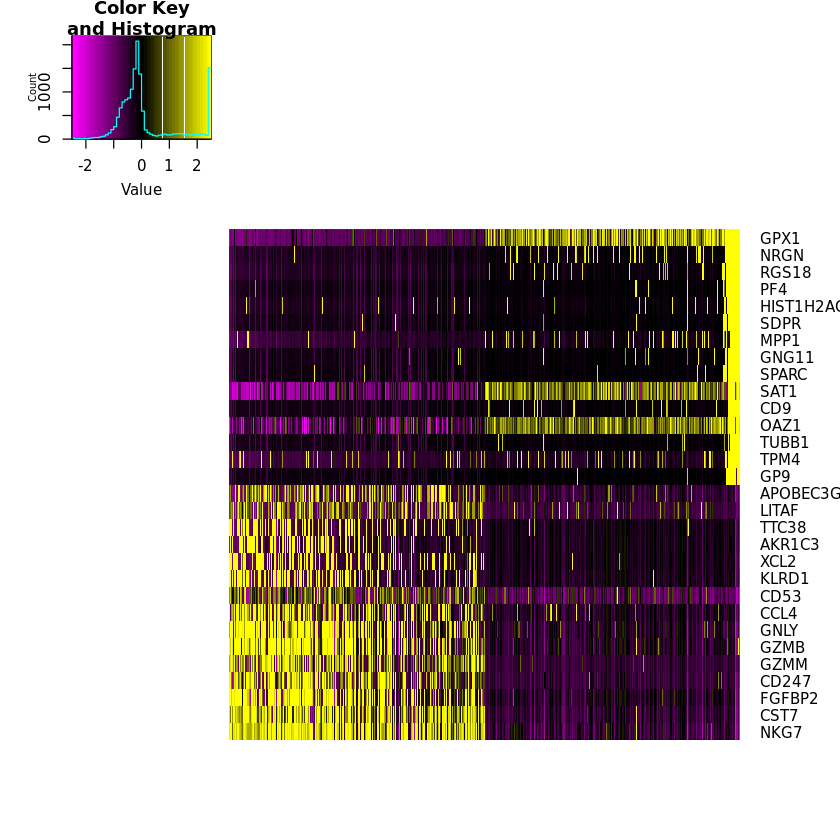

In [41]:
PCHeatmap(object = pbmc, pc.use = 1, cells.use = 500, do.balanced = TRUE, label.columns = FALSE)

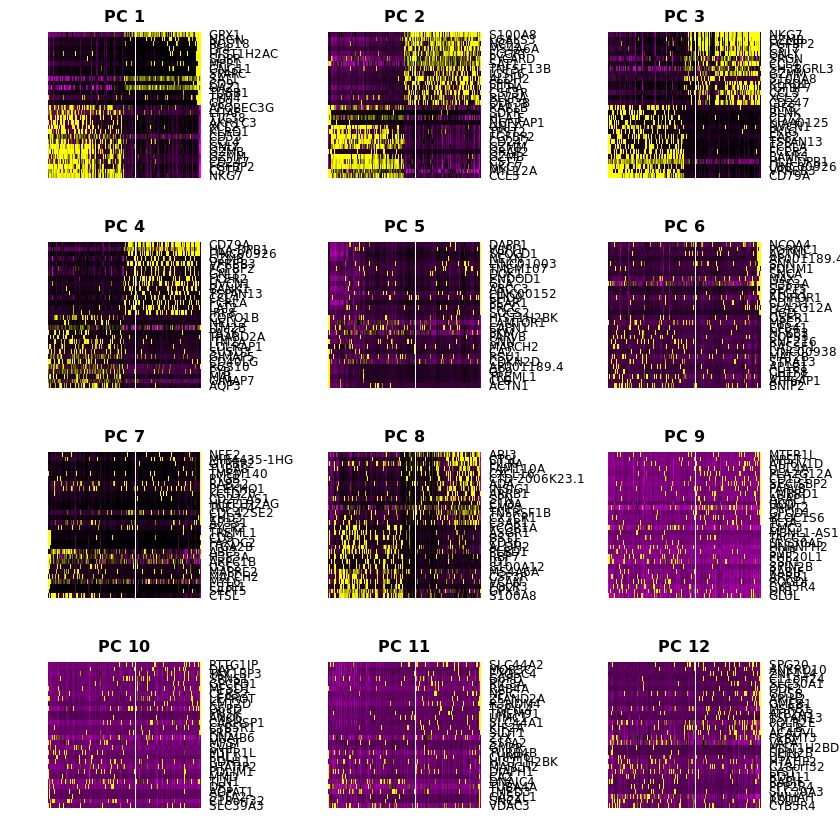

In [42]:
PCHeatmap(object = pbmc, pc.use = 1:12, cells.use = 500, do.balanced = TRUE, 
          label.columns = FALSE, use.full = FALSE)

## PC selection

Identifying the true dimensionality of a dataset – is an important step for Seurat, but can be challenging/uncertain for the user. We therefore suggest these three approaches to consider.

- The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example.
- The second implements a statistical test based on a random null model, but is time-consuming for large datasets, and may not return a clear PC cutoff. 
- The third is a heuristic that is commonly used, and can be calculated instantly. 

In this example, all three approaches yielded similar results, but we might have been justified in choosing anything between PC 7-10 as a cutoff. We followed the jackStraw here, admittedly buoyed by seeing the PCHeatmap returning interpretable signals (including canonical dendritic cell markers) throughout these PCs. Though the results are only subtly affected by small shifts in this cutoff (you can test below), we strongly suggest always explore the PCs they choose to include downstream.

<div class="alert alert-block alert-warning">
NOTE: This process can take a long time for big datasets, comment out forexpediency. More approximate techniques such as those implemented in PCElbowPlot() can be used to reduce computation time <br><br>

<br>
<code>pbmc <- JackStraw(object = pbmc, num.replicate = 100, display.progress = FALSE)</code>

</div>

A more ad hoc method for determining which PCs to use is to look at a plot of the standard deviations of the principle components and draw your cutoff where there is a clear elbow in the graph. This can be done with PCElbowPlot. In this example, it looks like the elbow would fall around PC 9.

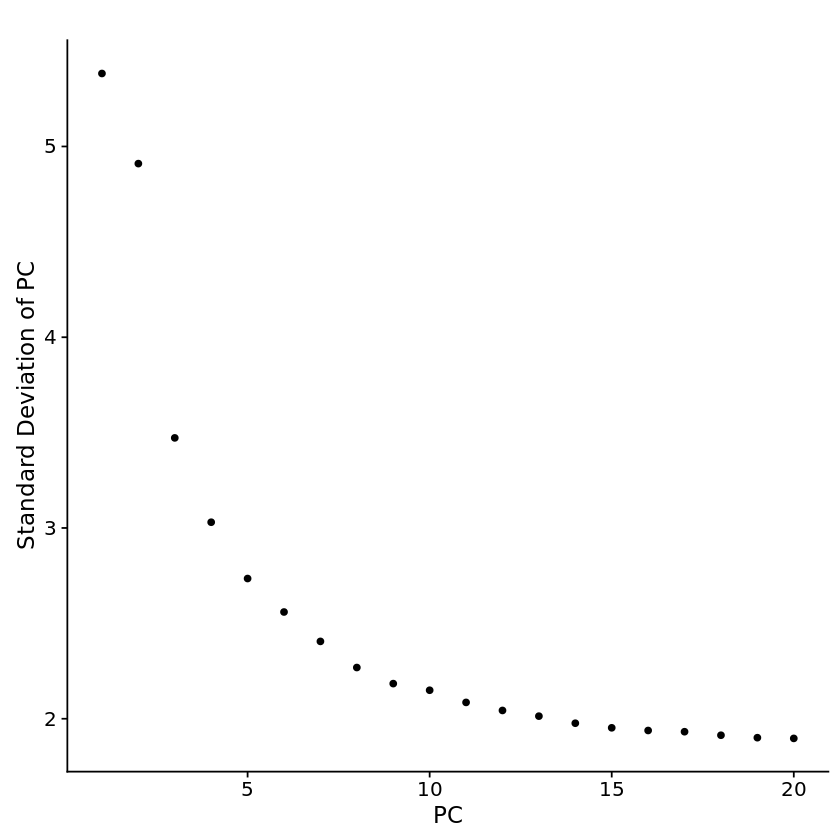

In [43]:
PCElbowPlot(object = pbmc)

# Cluster the cells

Seurat now includes an graph-based clustering approach compared to (Macosko et al.). Importantly, the distance metric which drives the clustering analysis (based on previously identified PCs) remains the same. However, our approach to partioning the cellular distance matrix into clusters has dramatically improved. Our approach was heavily inspired by recent manuscripts which applied graph-based clustering approaches to scRNA-seq data [SNN-Cliq, Xu and Su, Bioinformatics, 2015] and CyTOF data [PhenoGraph, Levine et al., Cell, 2015]. Briefly, these methods embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar gene expression patterns, and then attempt to partition this graph into highly interconnected ‘quasi-cliques’ or ‘communities’. As in PhenoGraph, we first construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). To cluster the cells, we apply modularity optimization techniques such as the Louvain algorithm (default) or SLM [SLM, Blondel et al., Journal of Statistical Mechanics], to iteratively group cells together, with the goal of optimizing the standard modularity function.

The FindClusters function implements the procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 0.6-1.2 typically returns good results for single cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters are saved in the object@ident slot.

<div class="alert alert-block alert-info">

INFO: save.SNN = T saves the SNN so that the clustering algorithm can be rerun using the same graph but with a different resolution value (see docs forfull details)

</div>

In [44]:
pbmc <- FindClusters(object = pbmc, reduction.type = "pca", dims.use = 1:10, 
                     resolution = 0.6, print.output = 0, save.SNN = TRUE)

# Run Non-linear dimensional reduction (tSNE)

Seurat continues to use tSNE as a powerful tool to visualize and explore these datasets. Cells within the graph-based clusters determined above should co-localize on the tSNE plot. This is because the tSNE aims to place cells with similar local neighborhoods in high-dimensional space together in low-dimensional space. As input to the tSNE, it is suggested using the same PCs as input to the clustering analysis, although computing the tSNE based on scaled gene expression is also supported using the __`genes.use`__ argument.

In [45]:
pbmc <- RunTSNE(object = pbmc, dims.use = 1:10, do.fast = TRUE)

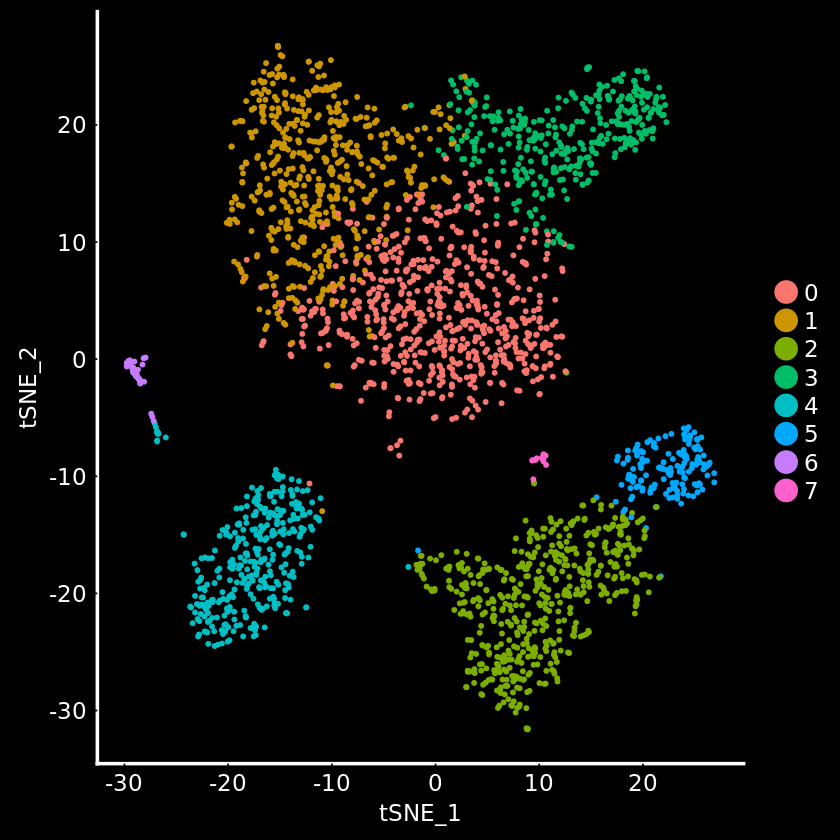

In [46]:
# note that you can set do.label=T to help label individual clusters
TSNEPlot(object = pbmc, dark.theme=T)

In [47]:
#save(pbmc,file="~/workshop_materials/scrna_workshop_data/pbmc_from_sce.rds")

# Assigning cell type identity to clusters



Fortunately in the case of this dataset, we can use canonical markers to easily match the unbiased clustering to known cell types:

    Cluster ID	Markers	Cell Type
    0	IL7R	CD4 T cells
    1	CD14, LYZ	CD14+ Monocytes
    2	MS4A1	B cells
    3	CD8A	CD8 T cells
    4	FCGR3A, MS4A7	FCGR3A+ Monocytes
    5	GNLY, NKG7	NK cells
    6	FCER1A, CST3	Dendritic Cells
    7	PPBP	Megakaryocytes

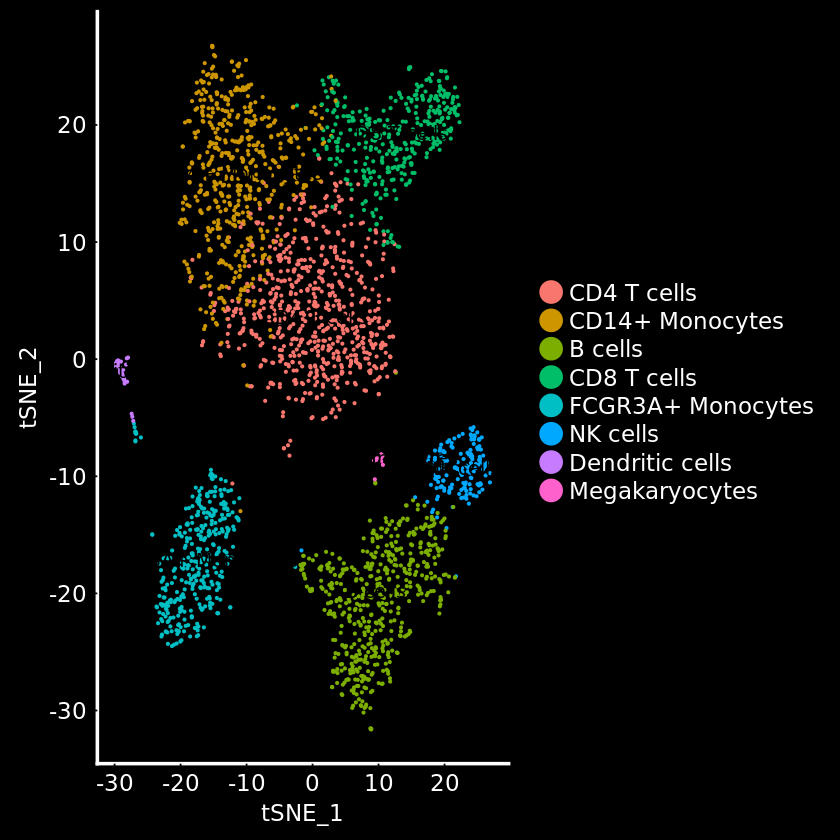

In [48]:
current.cluster.ids <- c(0, 1, 2, 3, 4, 5, 6, 7)

new.cluster.ids <- c("CD4 T cells", "CD14+ Monocytes",
                     "B cells", "CD8 T cells", "FCGR3A+ Monocytes",
                     "NK cells", "Dendritic cells", "Megakaryocytes")
pbmc@ident <- plyr::mapvalues(x = pbmc@ident, from = current.cluster.ids, to = new.cluster.ids)
TSNEPlot(object = pbmc, do.label = TRUE, pt.size = 0.5, dark.theme=T)